In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
import sys
import seaborn as sns
import matplotlib.pyplot as plt

#For woring in Google Colab Directory
drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/COMP 642/proj/')
path = '/content/gdrive/My Drive/COMP 642/proj/'

import prepare_edr
import tensorflow as tf
import keras


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


Using TensorFlow backend.


In [4]:
#load data from our pre-processing class
test_data = prepare_edr.PrepareEDR(path + "well_1.csv")
#Architecture contains the scaler so we can quickly back-out the original data if we wanted to.
X_train, y_train, X_test, y_test, headers_X, headers_Y, data_scaler = test_data.getLateralData(13000, 15000)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(662, 9)
(662,)
(166, 9)
(166,)


In [6]:
#Keras / Tensorflow2 MLP Implementation. 
#First, implement a single iteration model.
#Then, build a framework to run randomized CV search to tune hyperparameters

keras.backend.clear_session

#Need input_shape argument passed to the first layer.
#Note - in the case we are training on data with all off-bottom points removed, 
#then only train on 8 features
MLP_model = keras.models.Sequential([                                
                                     keras.layers.Dense(300, activation="relu", input_shape=(8,)),
                                     keras.layers.Dropout(rate=0.2),
                                     keras.layers.Dense(50, activation="relu"),
                                     keras.layers.Dropout(rate=0.2),
                                     #One output neuron per dimension; we are univariate predictor
                                     #No activation function for the output.
                                     keras.layers.Dense(1)  
])
MLP_model.summary()
#keras.utils.plot_model(MLP_model)

#Model parameters
lr = 3e-3
momentum = 0.2
#Leave this parameter in case we decide to go back to using momentum in the future.
#sgd_momentum = keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=False)
batch_size = 32
validation_split = 0.05
epochs = 100

MLP_model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.SGD(lr=lr),
    metrics=['mean_squared_error']
)

#implement early stopping and model training
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 8, restore_best_weights=True)

#Note - in the case we are training on data with all off-bottom points removed, 
#then only train on the last 8 features.
MLP_model_history = MLP_model.fit(X_train[:,1:], y_train, epochs=epochs, batch_size=72,
                                  validation_split=0.1, shuffle=True,
                                  callbacks=[early_stopping_cb])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               2700      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                15050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 17,801
Trainable params: 17,801
Non-trainable params: 0
_________________________________________________________________
Train on 595 samples, validate on 67 samples
Epoch 1/100
595/595 [==============================] - 0s 499us/step - 

In [8]:
#test our model output

from math import sqrt
from sklearn.metrics import mean_squared_error
y_est = MLP_model.predict(X_test[:, 1:])

test_set = np.concatenate((X_test, np.expand_dims(y_test, axis=1)), axis=1)
test_set_predicted = np.concatenate((X_test, y_est), axis=1)

test_inv = data_scaler.inverse_transform(test_set)
y_test_inv = test_inv[:,9]
y_est_inv = data_scaler.inverse_transform(test_set_predicted)[:,9]

headers_with_estimates = np.append(headers_X, ["ROP", "Estimated ROP"])
test_set_with_estimates = pd.DataFrame(data = np.concatenate((test_inv, np.expand_dims(y_est_inv, axis=1)), axis=1), 
                                                             columns = headers_with_estimates)


rmse = sqrt(mean_squared_error(y_test_inv, y_est_inv))
print('Test RMSE: %.2f' % rmse)
test_set_with_estimates

Test RMSE: 35.49


,Bit Depth / Hole Depth,Rotary RPM,Weight on Bit,Total Pump Output,Block Movement: + / - / 0,Differential Pressure,Hook Load,Standpipe Pressure,Convertible Torque,ROP,Estimated ROP
0,1.0,49.65,17.2,348.68,0.0,254.72,223.1,4978.14,7.146,10.76,32.514839
1,1.0,55.69,24.5,349.29,0.0,132.38,219.5,4997.79,5.971,26.88,40.556049
2,1.0,54.74,27.2,350.52,0.0,213.64,222.6,5012.64,7.738,63.88,54.685387
3,1.0,49.62,17.8,349.91,0.0,32.82,216.1,4936.64,6.518,27.00,20.892140
4,1.0,61.30,15.7,348.07,0.0,143.49,248.0,4896.82,12.294,41.75,75.976639
...,...,...,...,...,...,...,...,...,...,...,...
161,1.0,49.65,21.7,348.68,0.0,276.67,216.6,5000.10,5.281,35.17,31.414580
162,1.0,54.76,19.6,349.91,0.0,181.14,231.4,4934.45,6.534,22.00,25.556037
163,1.0,119.89,32.6,352.98,-1.0,1016.57,216.0,5815.57,15.492,339.17,367.987138
164,1.0,49.65,6.6,348.68,0.0,243.62,222.6,5013.47,5.531,37.16,20.214519


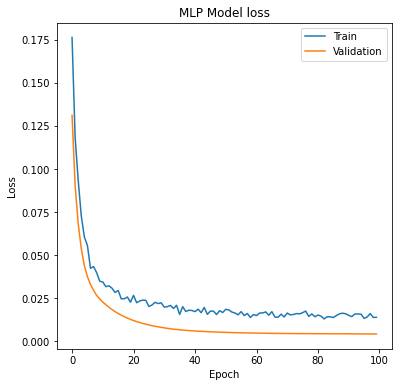

In [9]:
#Plot the loss reduction history over training epochs. 
plt.figure(figsize=(6,6))
plt.plot(MLP_model_history.history['loss'])
plt.plot(MLP_model_history.history['val_loss'])
plt.title('MLP Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#Note - we see this change in loss because we are using stochastic gradient descent

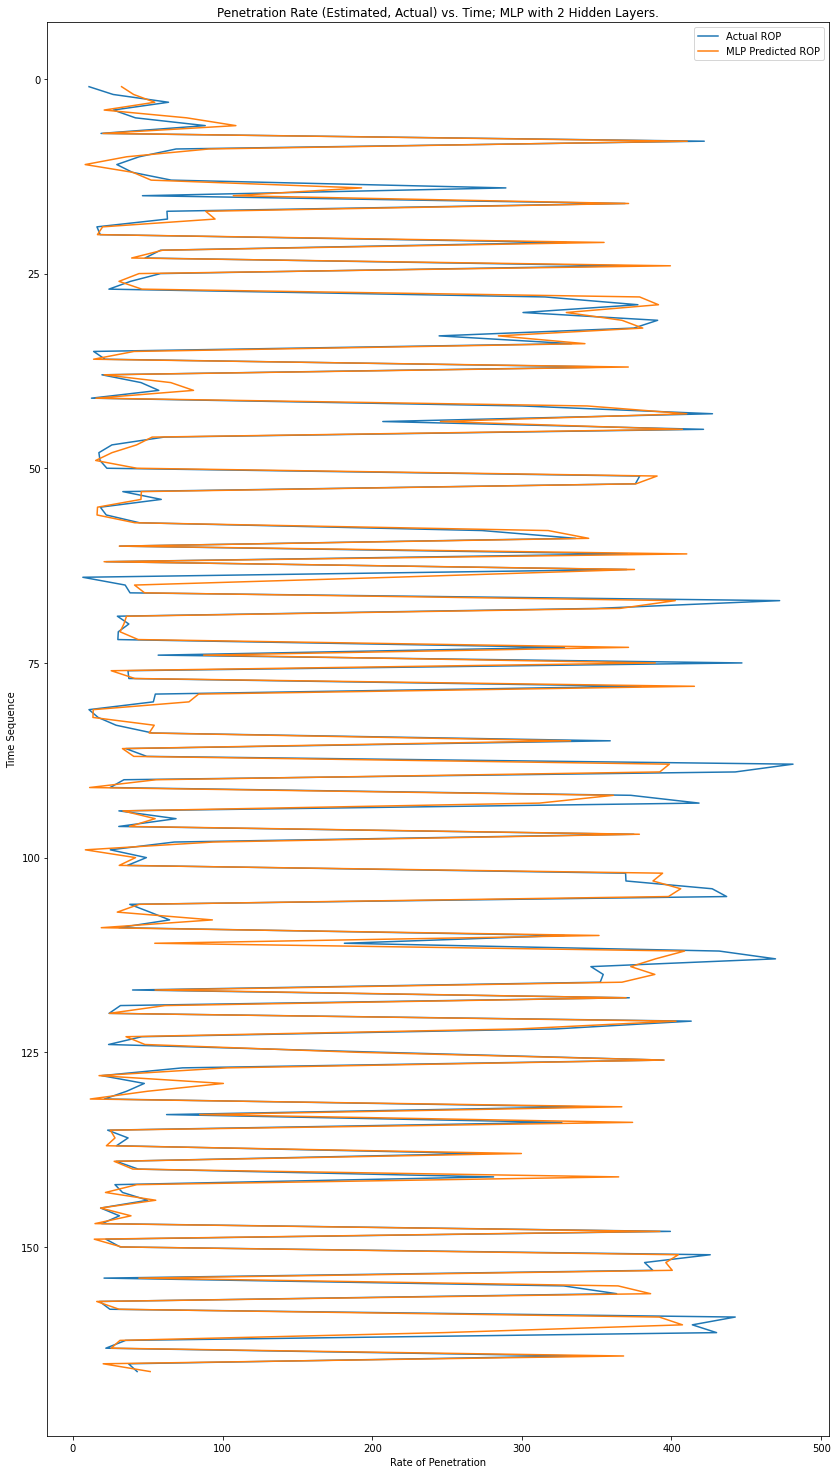

In [10]:
time_estimate_ROP = range(1, len(test_set_with_estimates) + 1)
plt.figure(figsize=(14,26))
plt.gca().invert_yaxis()
plt.plot("ROP", time_estimate_ROP, data=test_set_with_estimates)
plt.plot("Estimated ROP", time_estimate_ROP, data=test_set_with_estimates)
plt.legend(['Actual ROP', 'MLP Predicted ROP'])
plt.title('Penetration Rate (Estimated, Actual) vs. Time; MLP with 2 Hidden Layers.')
plt.xlabel('Rate of Penetration')
plt.ylabel('Time Sequence')
plt.show()

In [0]:
###Advanced optimization of MLP network (Part 4 of Report)###
#Now, an experimentation framework to explore different hyperparameter tuning values. 
keras.backend.clear_session

def build_model(n_hidden=1, n_neurons=50, learning_rate = 3e-3, input_shape=(9,), dropout=0.2):
  model = keras.models.Sequential()
  model.add(keras.layers.InputLayer(input_shape=input_shape))
  for i in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dropout(rate=dropout))
  model.add(keras.layers.Dense(1))
  optimizer=keras.optimizers.SGD(lr=learning_rate)
  model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error'])
  return model

In [0]:
#Wrapper to implement Randomized CV paramaeter search with Keras Sequential API model.
keras_regression_wrap = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [0]:
# keras_regression_wrap.fit(X_train, y_train, epochs=100, 
#                           validation_split=0.2, 
#                           callbacks=[early_stopping_cb])
# mse_test = keras_regression_wrap.score(X_test, y_test)

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV


param_distribs = {
    "n_hidden": [1, 2],
    "n_neurons": np.arange(10, 500, 50).tolist(),
    "learning_rate": np.linspace(3e-4, 3e-2, num=50, endpoint=True, retstep=False, dtype=None, axis=0).tolist(),#np.arange(3e-4, 3e-2),
    "dropout": [0, 0.1, 0.2]
}

rnd_search_cv = RandomizedSearchCV(keras_regression_wrap, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=100, 
                  validation_split=0.1,
                  callbacks=[keras.callbacks.EarlyStopping(patience = 8, restore_best_weights=True)])

Streaming output truncated to the last 5000 lines.
507/507 [==============================] - 0s 45us/step - loss: 0.0189 - val_loss: 0.0089
Epoch 10/100
507/507 [==============================] - 0s 50us/step - loss: 0.0166 - val_loss: 0.0084
Epoch 11/100
507/507 [==============================] - 0s 51us/step - loss: 0.0164 - val_loss: 0.0081
Epoch 12/100
507/507 [==============================] - 0s 48us/step - loss: 0.0153 - val_loss: 0.0078
Epoch 13/100
507/507 [==============================] - 0s 55us/step - loss: 0.0165 - val_loss: 0.0075
Epoch 14/100
507/507 [==============================] - 0s 53us/step - loss: 0.0156 - val_loss: 0.0075
Epoch 15/100
507/507 [==============================] - 0s 51us/step - loss: 0.0149 - val_loss: 0.0071
Epoch 16/100
507/507 [==============================] - 0s 51us/step - loss: 0.0147 - val_loss: 0.0070
Epoch 17/100
507/507 [==============================] - 0s 60us/step - loss: 0.0136 - val_loss: 0.0069
Epoch 18/100
507/507 [=============

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f5ad65da6d8>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'dropout': [0, 0.1, 0.2],
                                        'learning_rate': [0.0003,
                                                          0.0009061224489795917,
                                                          0.0015122448979591834,
                                                          0.0021183673469387754,
                                                          0.002724489795918367,
                                                          0.003330612244897959,
                                                          0.00393673469387755...
                                                          0.013028571428571426,
                                                          0.013634693877551018,
                     

In [0]:
rnd_search_cv.best_params_

{'dropout': 0.1,
 'learning_rate': 0.02090816326530612,
 'n_hidden': 2,
 'n_neurons': 210}

In [0]:
MLP_optimal_model = rnd_search_cv.best_estimator_.model

In [0]:
#After identifying the best hyperparameters without overfitting and without exposure to 
#the testing data, now predict and assess performance on the test set. 

#As the previous training takes significant time; rather than extracting the selected
#model from RandomizedSearchCV.best_estimator_.model; just make a new model with the extracted 
# parameters. Also, add dropout. The RandomizedSearchCV selecting a model without dropout is a 
# reflection that the model may be overfitting. 
keras.backend.clear_session

#Need input_shape argument passed to the first layer.
MLP_model_optimal = keras.models.Sequential([                                
                                     keras.layers.Dense(210, activation="relu", input_shape=(9,)),
                                     keras.layers.Dropout(rate=0.1),
                                     keras.layers.Dense(210, activation="relu"),
                                     keras.layers.Dropout(rate=0.1),
                                     keras.layers.Dense(1)  
])

#Model parameters - from RandomizedSearchCV.best_estimator_.model
lr = 0.02090816326530612
batch_size = 32
validation_split = 0.1
epochs = 100
callbacks = [keras.callbacks.EarlyStopping(patience = 8, restore_best_weights=True)]

MLP_model_optimal.compile(
    loss='mse',
    optimizer=keras.optimizers.SGD(lr=lr),
)

MLP_model_optimal_history = MLP_model.fit(X_train, y_train, epochs=epochs, 
                                           validation_split=validation_split, callbacks=callbacks)



#Test on the test data; and compare RMSE with actual units (inverted with the scaler)
y_est = MLP_model_optimal.predict(X_test)


Train on 760 samples, validate on 191 samples
Epoch 1/100
760/760 [==============================] - 0s 61us/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_percentage_error: 22153060.0000 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_percentage_error: 13855807.0000
Epoch 2/100
760/760 [==============================] - 0s 64us/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_percentage_error: 20852400.0000 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_percentage_error: 13721277.0000
Epoch 3/100
760/760 [==============================] - 0s 60us/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_percentage_error: 19409018.0000 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_percentage_error: 13587993.0000
Epoch 4/100
760/760 [==============================] - 0s 69us/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_percentage_error: 21782444.0000 - 

In [0]:
y_est = MLP_model_optimal.predict(X_test)

In [0]:
y_est.shape

(238, 1)

In [0]:
from math import sqrt
from sklearn.metrics import mean_squared_error

test_set = np.concatenate((X_test, np.expand_dims(y_test, axis=1)), axis=1)
test_set_predicted = np.concatenate((X_test, y_est), axis=1)

test_inv = data_scaler.inverse_transform(test_set)
y_test_inv = test_inv[:,9]
y_est_inv = data_scaler.inverse_transform(test_set_predicted)[:,9]

headers_with_estimates = np.append(headers_X, ["ROP", "Estimated ROP"])
test_set_with_estimates = pd.DataFrame(data = np.concatenate((test_inv, np.expand_dims(y_est_inv, axis=1)), axis=1), 
                                                             columns = headers_with_estimates)


rmse = sqrt(mean_squared_error(y_test_inv, y_est_inv))
print('Test RMSE: %.2f' % rmse)
test_set_with_estimates

Test RMSE: 200.73


,Bit Depth / Hole Depth,Rotary RPM,Weight on Bit,Total Pump Output,Block Movement: + / - / 0,Differential Pressure,Hook Load,Standpipe Pressure,Convertible Torque,ROP,Estimated ROP
0,1.000000,54.74,24.3,349.29,0.0,240.09,224.6,5039.10,7.808,64.36,-20.994874
1,0.646220,0.05,0.0,0.00,0.0,0.00,46.9,0.00,0.000,0.00,5.726720
2,0.999892,0.08,0.0,0.00,1.0,0.00,41.8,0.00,0.000,0.00,10.971374
3,1.000000,54.63,25.5,347.45,0.0,216.65,225.6,4936.98,6.143,60.89,-22.264510
4,1.000000,49.62,9.2,349.29,0.0,197.23,218.4,4967.07,6.241,30.71,-25.188340
...,...,...,...,...,...,...,...,...,...,...,...
233,1.000000,119.78,27.9,349.29,-1.0,920.19,250.4,5770.34,13.182,252.70,-11.027939
234,0.999863,20.67,0.0,0.00,1.0,0.00,42.3,0.00,2.485,0.00,-0.654190
235,1.000000,61.30,15.7,348.07,0.0,143.49,248.0,4896.82,12.294,41.75,-22.660369
236,0.999946,49.65,2.3,350.52,0.0,0.00,242.8,4783.99,6.196,0.00,-31.271147


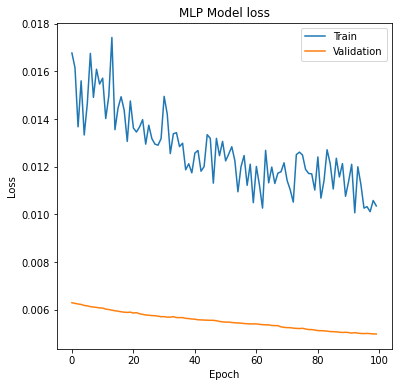

In [0]:
#Plot the loss reduction history over training epochs. 
plt.figure(figsize=(6,6))
plt.plot(MLP_model_optimal_history.history['loss'])
plt.plot(MLP_model_optimal_history.history['val_loss'])
plt.title('MLP Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#Note - we see this change in loss because we are using stochastic gradient descent

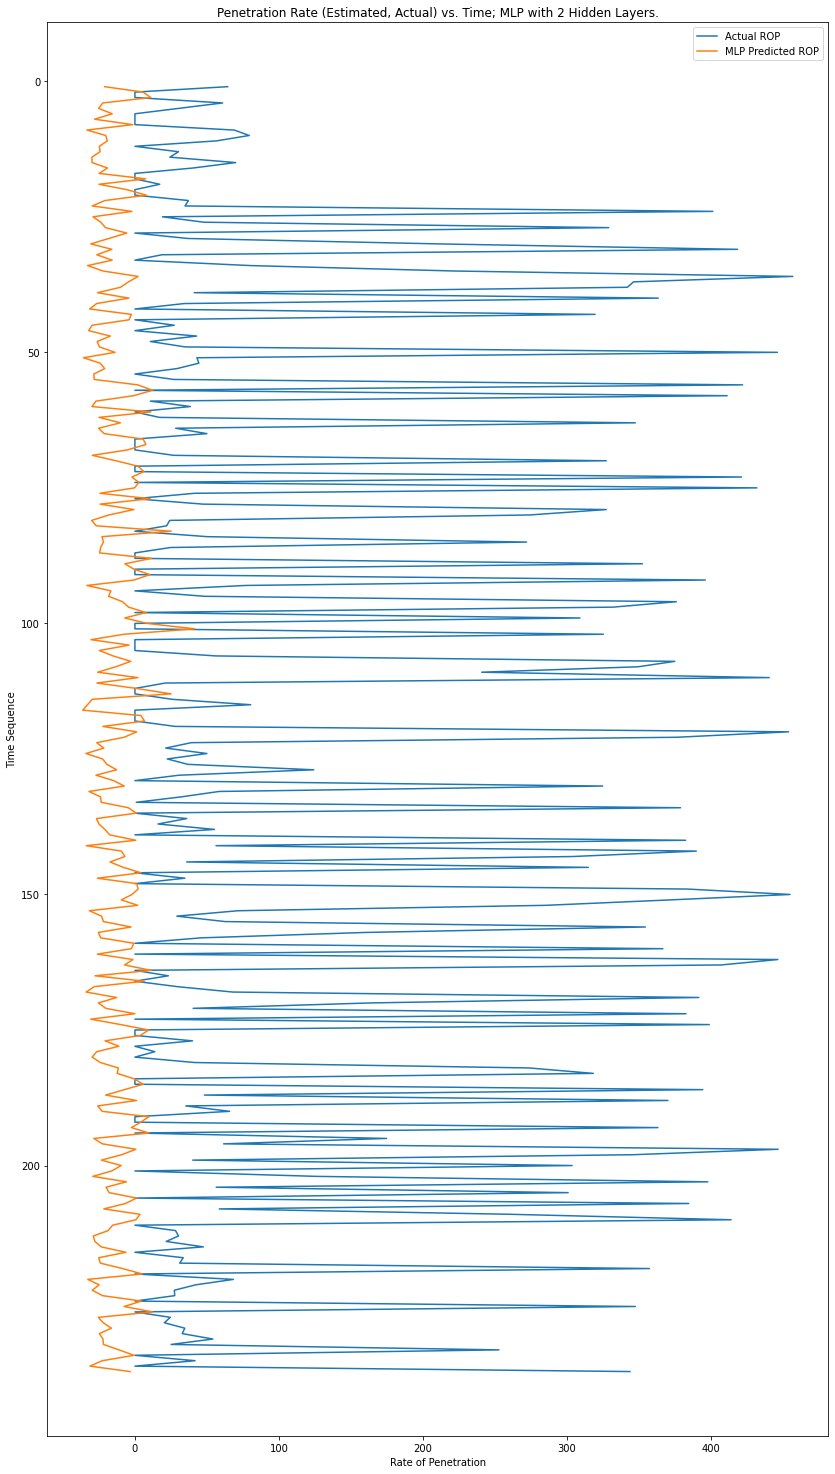

In [0]:
time_estimate_ROP = range(1, len(test_set_with_estimates) + 1)
plt.figure(figsize=(14,26))
plt.gca().invert_yaxis()
plt.plot("ROP", time_estimate_ROP, data=test_set_with_estimates)
plt.plot("Estimated ROP", time_estimate_ROP, data=test_set_with_estimates)
plt.legend(['Actual ROP', 'MLP Predicted ROP'])
plt.title('Penetration Rate (Estimated, Actual) vs. Time; MLP with 2 Hidden Layers.')
plt.xlabel('Rate of Penetration')
plt.ylabel('Time Sequence')
plt.show()